In [18]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
from casadi.tools import *
import do_mpc

The project is structured in 3 templates:
* Template model
* Template mpc
* Template simulator

$\textbf{Template model}$

The template model defines the mathematical model of the dynamical system. Here, we use the approximated function obtained from the Regression.ipynb file.

In [19]:
def template_model(symvar_type='SX'):
    """
    --------------------------------------------------------------------------
    template_model
    --------------------------------------------------------------------------
    """
    model_type = 'discrete' # either 'discrete' or 'continuous'
    model = do_mpc.model.Model(model_type, symvar_type)

    # Simple oscillating masses example with two masses and two inputs.
    # States are the position and velocitiy of the two masses.

    # State struct (optimization variables):
    _x = model.set_variable(var_type='_x', var_name='x', shape=(1,1))

    # Input struct (optimization variables):
    _u = model.set_variable(var_type='_u', var_name='u', shape=(1,1))

    # Set expression. These can be used in the cost function, as non-linear constraints
    # or just to monitor another output.
    model.set_expression(expr_name='cost', expr=sum1((_x-1500)**2))
    

    A = np.array([0.99])

    B = np.array([0.39])

    #mathematical model
    x_next = A@_x+B@_u
    
    model.set_rhs('x', x_next) #Formulate the right hand side (rhs) of the update equation

    model.setup()

    return model


$\textbf{Template mpc}$

The template mpc configures the MPC controller. The optimal control problem is given in the following form:

$$\min_{x, u, z} \sum_{k=0}^N(\underbrace{l(x_k, u_k)}_{lagrange\,term} + \underbrace{\Delta u_k^TR\Delta u_k)}_{r-\,term} + \underbrace{m(x_{N+1})}_{meyer\,term}$$

$$\begin{array}{ccc}
s.t. & x_{lb} \leq x_k \leq x_{ub} & \forall k = 0, \dots, N + 1\\
& u_{lb} \leq u_k \leq u_{ub} & \forall k = 0, \dots, N
\end{array}$$


In [20]:
def template_mpc(model):
    """
    --------------------------------------------------------------------------
    template_mpc: tuning parameters
    --------------------------------------------------------------------------
    """
    mpc = do_mpc.controller.MPC(model)

    setup_mpc = {
        'n_robust': 0,
        'n_horizon': 7,
        't_step': 0.5,
        'store_full_solution':True,
    }

    mpc.set_param(**setup_mpc)

    mterm = model.aux['cost'] # meyer term
    lterm = model.aux['cost'] # lagrange term

    mpc.set_objective(mterm=mterm, lterm=lterm)
    mpc.set_rterm(u=10000) #weights for rterm Δu*R*Δu

    min_x = np.array([0])    # minimum value for the position
    max_x = np.array([1500]) # maximum value for the position
    
    min_u = np.array([15]) # minimum value for the velocity
    max_u = np.array([85]) # maximum value for the velocity
    

    mpc.bounds['lower','_x','x'] = min_x # lower bound for the state x 
    mpc.bounds['upper','_x','x'] = max_x # upper bound for the state x 

    mpc.bounds['lower','_u','u'] = min_u # lower bound for the control input u
    mpc.bounds['upper','_u','u'] = max_u # upper bound for the control input u


    mpc.setup()

    return mpc

$\textbf{Template simulator}$

The template simulator allows to test firstly the developed approach on a simulated system.

In [21]:
def template_simulator(model):
    """
    --------------------------------------------------------------------------
    template_optimizer: tuning parameters
    --------------------------------------------------------------------------
    """
    simulator = do_mpc.simulator.Simulator(model) 


    simulator.set_param(t_step = 0.5) #set the time_step

    simulator.setup()

    return simulator

In order to test the reaction capabilities of the mpc controller, we have defined a function $random\_u$ with which the system has 80% chance to use the control input suggested by the mpc or a random value between 15 and 85 km/h. 

In [22]:
def random_u(u0):
    # Hold the current value with 80% chance or switch to new random value.
    u_next = np.random.randint(15,85)# New candidate value.
    switch = np.random.rand() >= 0.8 # switching? 0 or 1.
    u0 = (1-switch)*u0 + switch*u_next # Old or new value.
    return u0

In addition, we have the possibility to add some noise between the range 0 and 5 km/h in order to evaluate the performance of the closed loop system in presence of noise.

In [23]:
def add_noise(u0):
    # Add some noise, between 0 and 5 km/h, to the control input
    u0 = u0 + np.random.randint(0, 5) 
    return u0

In [24]:
""" User settings: """
_random_u = False 
_add_noise = True

"""
Get configured do-mpc modules:
"""
model = template_model()
mpc = template_mpc(model)
simulator = template_simulator(model)
estimator = do_mpc.estimator.StateFeedback(model)


"""
Set initial state
"""

x0 = np.array([0]) #the initial state must be 0 for our control problem
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0

# Use initial state to set the initial guess.
mpc.set_initial_guess()

"""
Run MPC main loop:
"""

for k in range(100):
    u0 = mpc.make_step(x0)
    if _random_u: #if _random_u is True, u0 holds the current value with 80% chance or switch to new random value
        # between 15 and 85 km/h.
        u0 = random_u(u0)
        
    if _add_noise:#if _add_noise is True, u0 can have some additional noise between 0 and 5 km/h 
        u0 = add_noise(u0)
    
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       22
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:       15
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       14
                     variables with only upper bounds:        0
Total number of equality constraints.................:        8
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

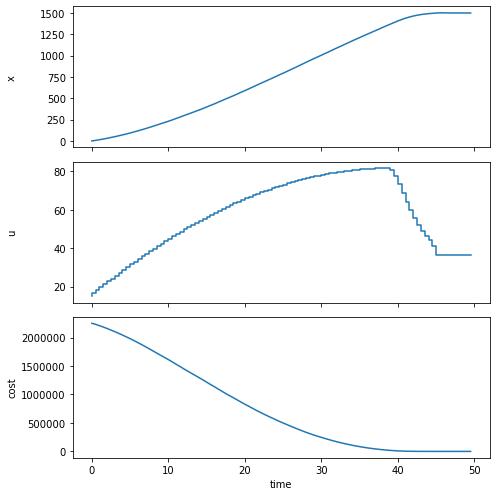

In [25]:
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(7,7))
graphics.plot_results()
graphics.reset_axes()
plt.show()